# Step 1 : Importing Essetial Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Step 2 : Importing Data and Creating a Dataframe

In [3]:
import os
import pandas as pd

train_dir = 'skin-lesion-analysis-towards-melanoma-detection/Train'
test_dir = 'skin-lesion-analysis-towards-melanoma-detection/Test'

# Create dataframes
train_data = []
test_data = []

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_data.append({'image_path': image_path, 'label': label})

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_data.append({'image_path': image_path, 'label': label})

# Create train_df and test_df from the lists of dictionaries
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)


In [4]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

# Step 3 : EDA

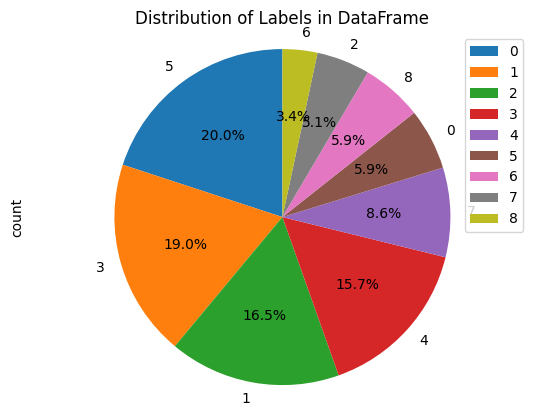

In [5]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [6]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              146       
1               basal cell carcinoma           408       
2               dermatofibroma                 127       
3               melanoma                       470       
4               nevus                          389       
5               pigmented benign keratosis     494       
6               seborrheic keratosis           83        
7               squamous cell carcinoma        213       
8               vascular lesion                145       
------------------------------------------------------------
Total                                         2475      


# Step 4 : Loading and resizing of images

In [7]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

In [8]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [9]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

2

In [10]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

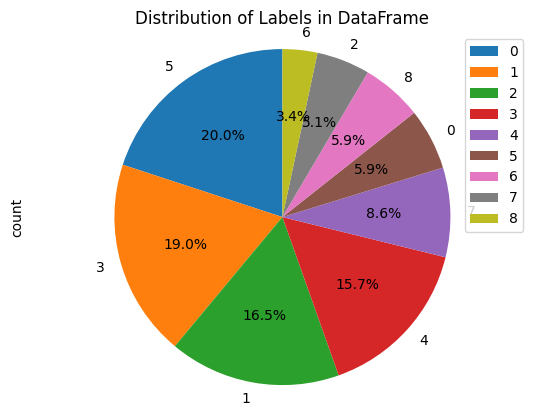

In [11]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [12]:
df.head()

,image_path,label,image
0,skin-lesion-analysis-towards-melanoma-detectio...,0,"[[[147, 118, 96], [147, 115, 91], [150, 117, 9..."
1,skin-lesion-analysis-towards-melanoma-detectio...,0,"[[[169, 164, 158], [169, 165, 158], [169, 166,..."
2,skin-lesion-analysis-towards-melanoma-detectio...,0,"[[[238, 144, 163], [237, 141, 159], [238, 134,..."
3,skin-lesion-analysis-towards-melanoma-detectio...,0,"[[[183, 128, 119], [180, 122, 113], [176, 118,..."
4,skin-lesion-analysis-towards-melanoma-detectio...,0,"[[[157, 126, 134], [161, 132, 140], [162, 135,..."


> # Displaying the total number of images of each Class before Data Augmentation

In [13]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              146       
1               basal cell carcinoma           408       
2               dermatofibroma                 127       
3               melanoma                       470       
4               nevus                          389       
5               pigmented benign keratosis     494       
6               seborrheic keratosis           83        
7               squamous cell carcinoma        213       
8               vascular lesion                145       
------------------------------------------------------------
Total                                         2475      


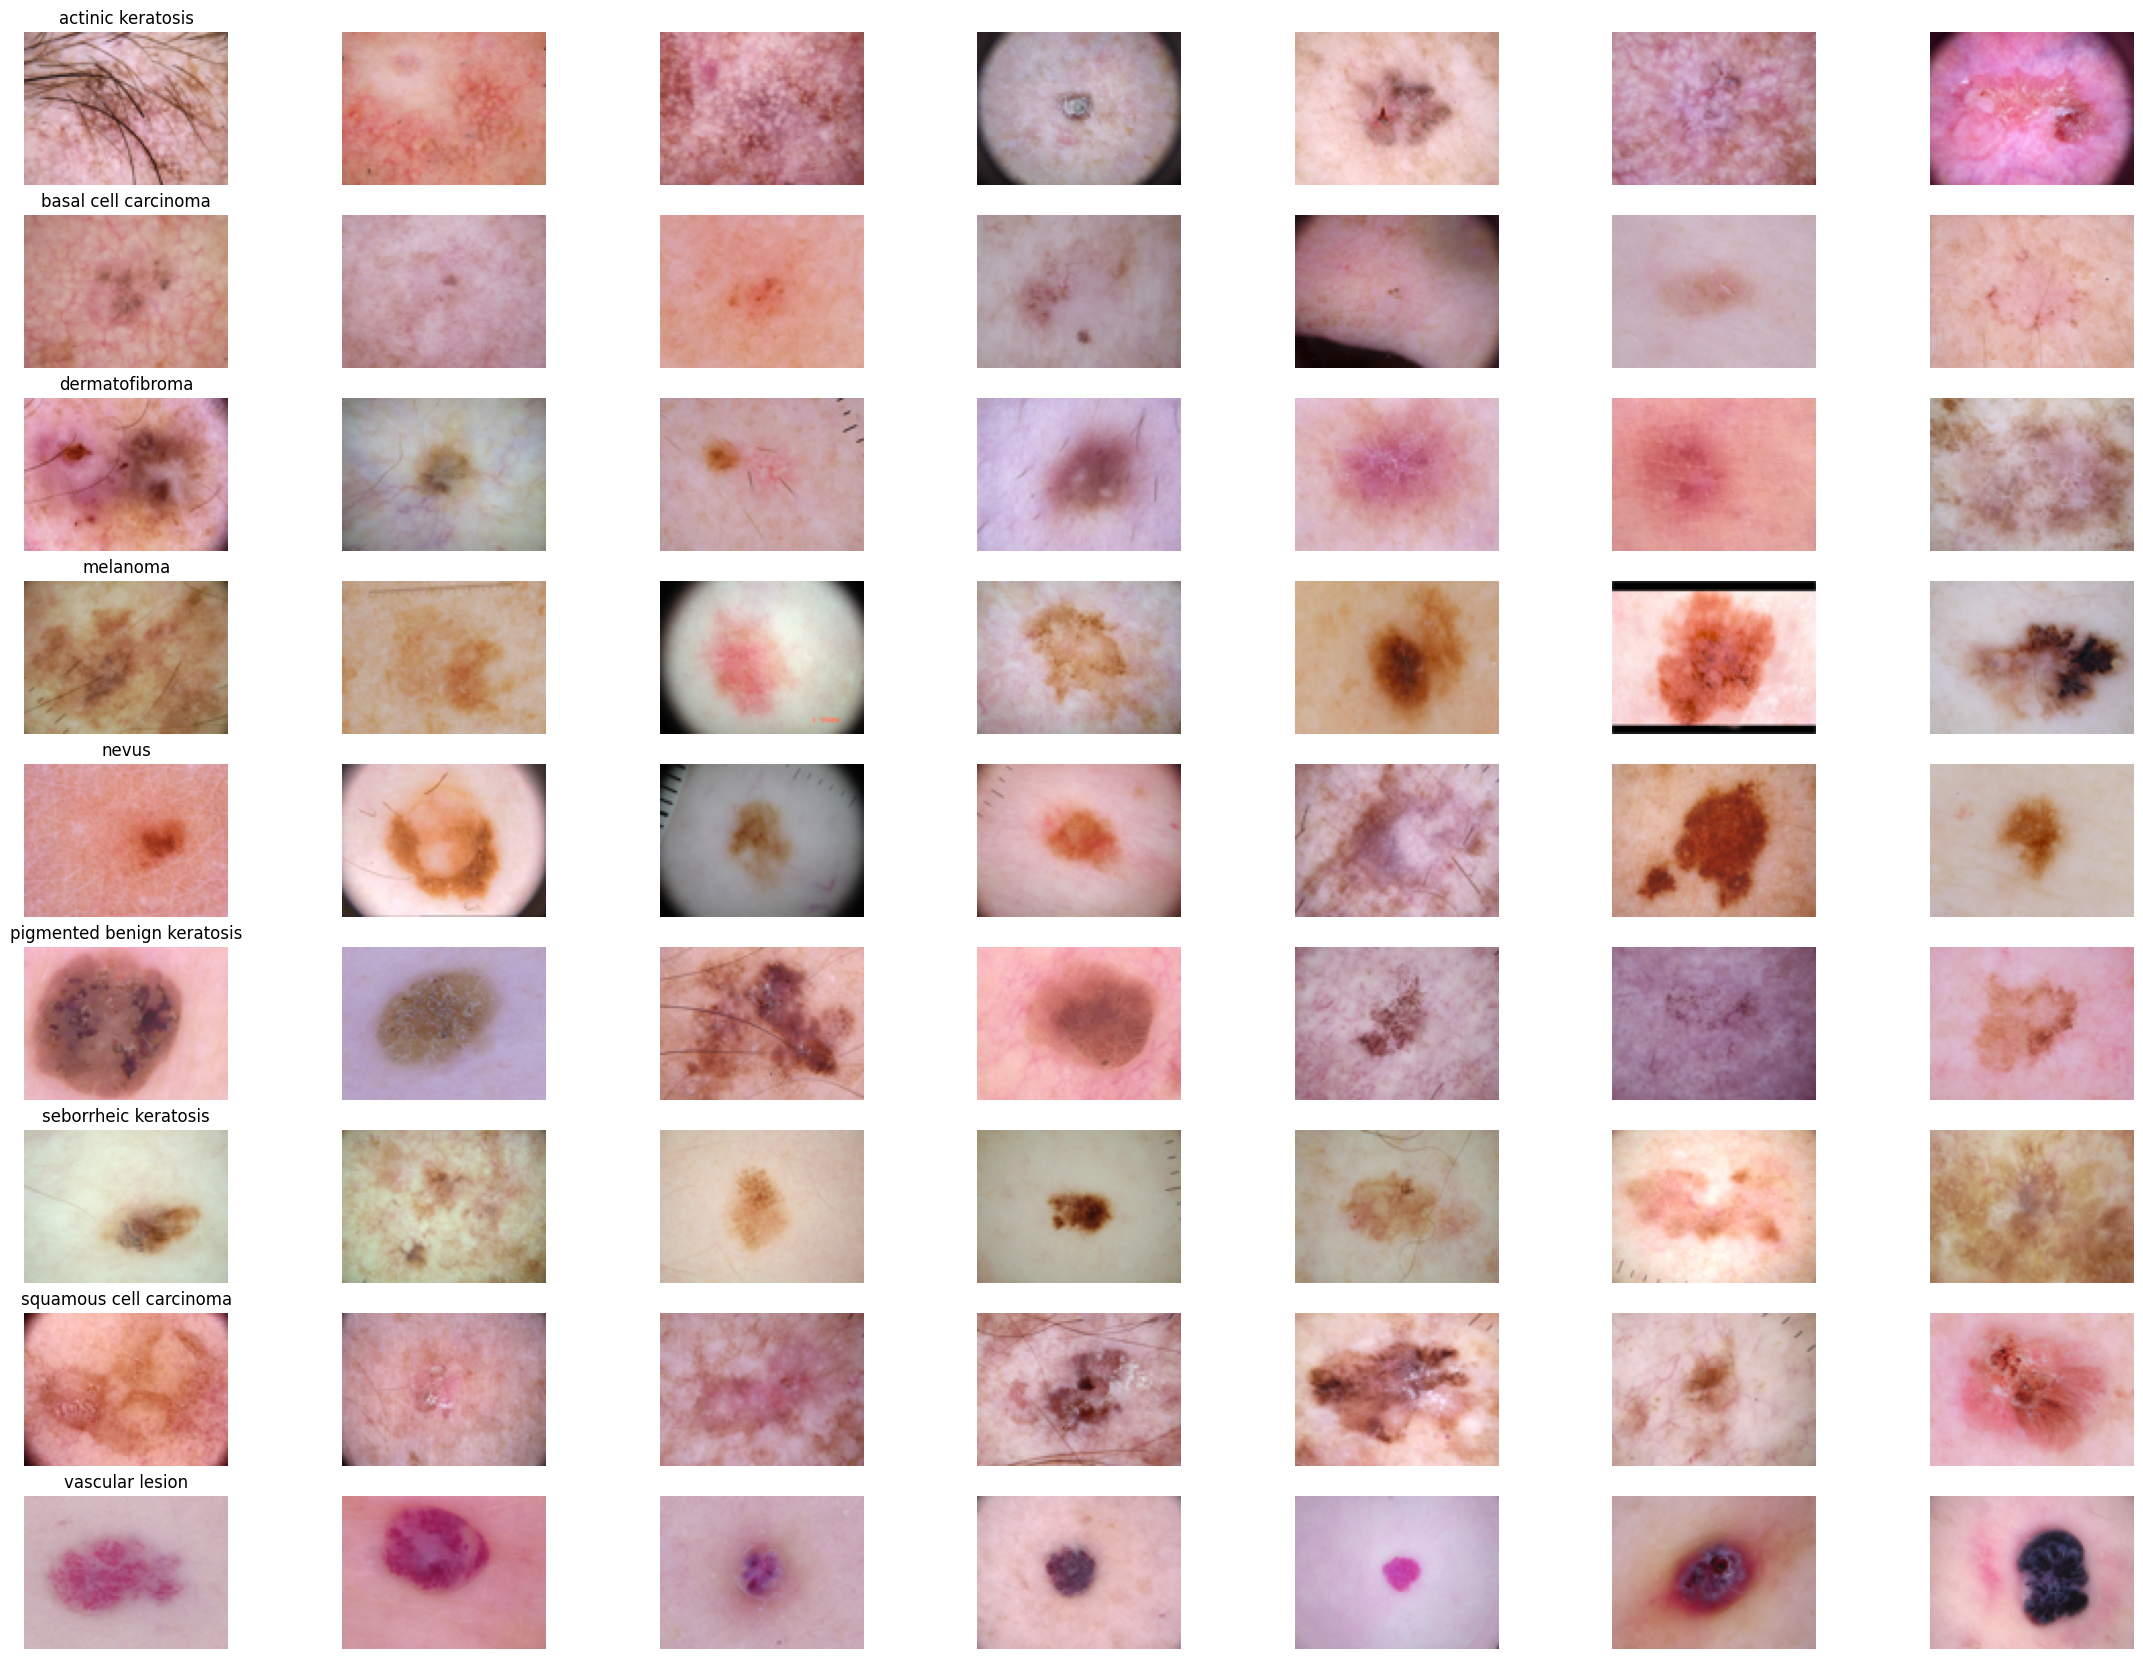

In [14]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [15]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    2475
Name: count, dtype: int64

# Step 5 : Data Augmentation

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [17]:
# Create an empty dataframe to store the augmented images
augmented_data = []

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_data.append({'image_path': None, 'label': class_label, 'image': augmented_image_array})
    
    # Add the original images for the current class to the augmented dataframe
    original_images_data = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_data.extend(original_images_data.to_dict('records'))

# Create the augmented dataframe from the list of dictionaries
augmented_df = pd.DataFrame(augmented_data)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

# Shuffle the dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

del augmented_df


> # Displaying the total number of images of each Class after Data Augmentation

In [18]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              2500      
1               basal cell carcinoma           2500      
2               dermatofibroma                 2500      
3               melanoma                       2500      
4               nevus                          2500      
5               pigmented benign keratosis     2500      
6               seborrheic keratosis           2500      
7               squamous cell carcinoma        2500      
8               vascular lesion                2500      
------------------------------------------------------------
Total                                         22500     


# Step 6 : Train and Test split

In [19]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [20]:
features.head()

,image
0,"[[[238, 192, 204], [239, 193, 204], [238, 191,..."
1,"[[[144, 140, 131], [144, 140, 131], [144, 140,..."
2,"[[[152, 123, 123], [153, 125, 124], [150, 120,..."
3,"[[[220, 209, 216], [220, 209, 216], [220, 209,..."
4,"[[[190, 173, 171], [190, 172, 171], [190, 172,..."


In [21]:
target.head()

0    0
1    3
2    7
3    3
4    4
Name: label, dtype: int64

In [22]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [23]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

# Step 7 : Normalization of Data

In [24]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 8 : Label Encoding

In [25]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# Step 9 : Splitting the data into training and Validation Split

In [26]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [27]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [28]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

> # Displaying the total number of images of each Class

In [29]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              1604       378          518        2500      
1               basal cell carcinoma           1566       444          490        2500      
2               dermatofibroma                 1600       393          507        2500      
3               melanoma                       1613       408          479        2500      
4               nevus                          1601       392          507        2500      
5               pigmented benign keratosis     1624       400          476        2500      
6               seborrheic keratosis           1572       409          519        2500      
7               squamous cell carcinoma        1625       

In [30]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [31]:
input_shape = df['image'][0].shape

# Step 10 : Model Architecture

In [32]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# DenseNet121
model = Sequential()
model.add(DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Step 11 : Setting Optimizer

In [33]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Step 12: Fitting of model

In [34]:
# Fit the model
epochs = 3    
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/3
450/450 [==============================] - 4815s 10s/step - loss: 1.1216 - accuracy: 0.5987 - val_loss: 0.7387 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 2/3
450/450 [==============================] - 5816s 13s/step - loss: 0.5013 - accuracy: 0.8145 - val_loss: 0.5046 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 3/3
450/450 [==============================] - 5626s 13s/step - loss: 0.2958 - accuracy: 0.8883 - val_loss: 0.3966 - val_accuracy: 0.8578 - lr: 0.0010


# Step 13 : Model Evaluation

In [35]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 1426s 3s/step - loss: 0.1398 - accuracy: 0.9498
Train: accuracy = 0.949792  ;  loss = 0.139760


In [36]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 477s 3s/step - loss: 0.3903 - accuracy: 0.8616
Testing: accuracy = 0.861556  ;  loss = 0.390272


141/141 [==============================] - 457s 3s/step


<AxesSubplot: >

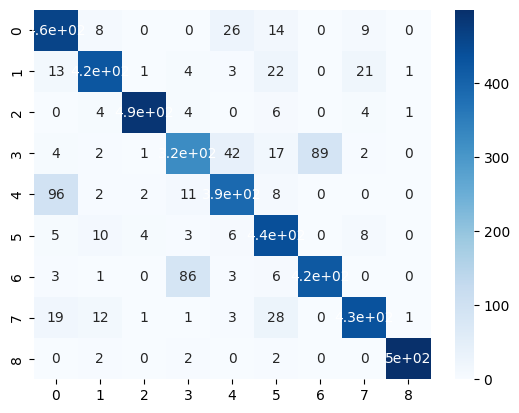

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.8616
Precision: 0.8629
Recall: 0.8610
F1-score: 0.8606
Kappa score: 0.8442


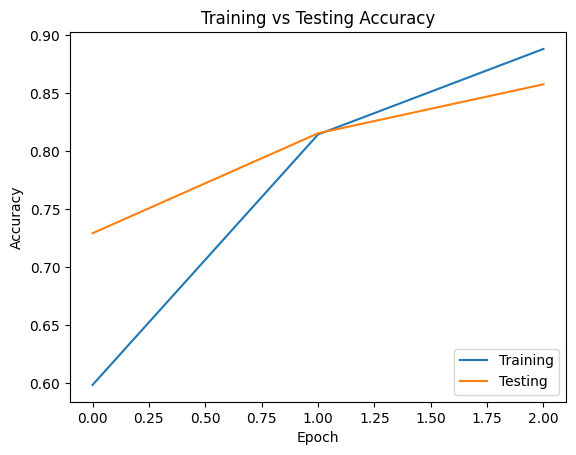

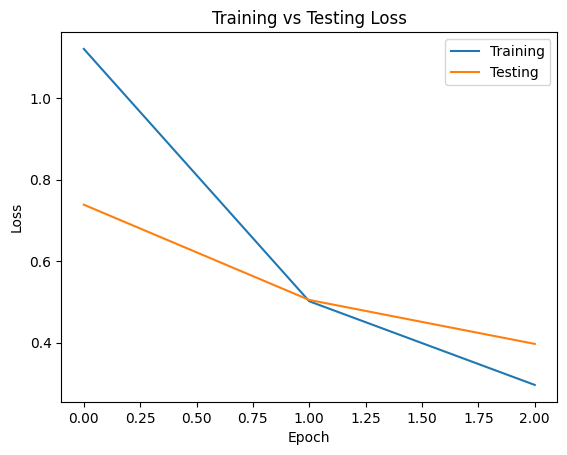

In [39]:
import matplotlib.pyplot as plt

# Get training and testing accuracy and loss histories
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
testing_loss = history.history['val_loss']

# Plot training and testing accuracy curves
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='lower right')
plt.show()

# Plot training and testing loss curves
plt.plot(training_loss)
plt.plot(testing_loss)
plt.title('Training vs Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper right')
plt.show()

# Step 14 : Saving the model

In [41]:
model.save("skinDiseaseDetectionUsningCNN.h5")

# Step 15: Program

In [42]:
import os
from flask import Flask, render_template, request
from werkzeug.utils import secure_filename
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Initialize Flask application
app = Flask(__name__)

# Load the skin cancer classifier model
model = load_model('skinDiseaseDetectionUsningCNN.h5')
categories = ['actinic keratosis','basal cell carcinoma','dermatofibroma', 'melanoma','nevus','pigmented benign keratosis','seborrheic keratosis', 'squamous cell carcinoma','vascular lesion']

# Define allowed file extensions
ALLOWED_EXTENSIONS = {'jpg', 'jpeg', 'png'}

# Configure upload folder
UPLOAD_FOLDER = 'uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER


def allowed_file(filename):
    # Check if the file has an allowed extension
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


def preprocess_image(image):
    # Preprocess the image for prediction
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))  # Adjust the size according to the model requirements
    image = image.astype('float32') / 255.0
    return image


def classify_image(image):
    # Classify the image using the loaded model
    preprocessed_image = preprocess_image(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    prediction = model.predict(preprocessed_image)
    predicted_label = categories[np.argmax(prediction)]
    return predicted_label


@app.route('/')
def index():
    # Render the index.html template
    return render_template('index.html')


@app.route('/upload', methods=['POST'])
def upload():
    # Handle file upload from the front-end
    if 'file' not in request.files:
        return 'No file uploaded', 400

    file = request.files['file']

    if file.filename == '':
        return 'No selected file', 400

    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(filepath)

        # Load and classify the uploaded image
        image = cv2.imread(filepath)
        predicted_label = classify_image(image)

        # Remove the uploaded file
        os.remove(filepath)

        return f'Predicted label: {predicted_label}'

    return 'Invalid file', 400


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
